In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as datasets
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid


import numpy as np
import matplotlib.pyplot as plt
import random

from utility import *
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
def set_random_seed(SEED=1234):
   random.seed(SEED)
   np.random.seed(SEED)
   torch.manual_seed(SEED)
   torch.cuda.manual_seed(SEED)
   torch.cuda.manual_seed_all(SEED)
   torch.backends.cudnn.enabled = True
   torch.backends.cudnn.benchmark = False
   torch.backends.cudnn.deterministic = True

set_random_seed()

In [17]:
import os

def plot_images(images, padding=1):
    """
    Plot images on a grid with small white gaps between them.
    
    Args:
    images (torch.Tensor): 4D tensor of shape (batch_size, channels, height, width)
    padding (int): Number of pixels for padding between images
    """
    # Normalize and convert to uint8
    images = (images * 127.5 + 128).clip(0, 255).to(torch.uint8)
    
    # Create grid with small padding and no normalization
    sample_grid = make_grid(images, nrow=int(np.sqrt(images.shape[0])), 
                            padding=padding, normalize=False, 
                            pad_value=255)  # White padding
    
    # Create figure
    plt.figure(figsize=(10, 10))
    
    # Display image
    plt.imshow(sample_grid.cpu().permute(1, 2, 0).squeeze())
    plt.axis('off')
    
    # Remove any potential remaining space around the image
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.margins(0, 0)
    save_path = os.getcwd()
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    
    plt.show()

In [18]:
def load_dataset():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    #dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

    return dataset

In [19]:
# this function is written to find closest image in a dataset and compute its distance
def find_closest_images(dataset, batch_size=1000):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    all_images = []
    
    # Flatten and normalize all images
    for images, _ in dataloader:
        images = images.view(images.size(0), -1)
        images = (images - images.mean(dim=1, keepdim=True)) / images.std(dim=1, keepdim=True)
        all_images.append(images)
    
    all_images = torch.cat(all_images)
    
    closest_indices = []
    closest_distances = []
    
    for i in range(0, len(dataset), batch_size):
        batch = all_images[i:i+batch_size]
        
        # Compute correlation
        correlation = torch.mm(batch, all_images.t())
        
        # Set self-correlation to -1 to exclude it from max
        correlation[torch.arange(correlation.size(0)), torch.arange(i, i+correlation.size(0))] = -1
        
        # Find index of max correlation
        _, max_indices = correlation.max(dim=1)
        closest_indices.extend(max_indices.tolist())
        
        # Compute Euclidean distance
        distances = torch.norm(batch - all_images[max_indices], dim=1)
        closest_distances.extend(distances.tolist())
        
        #print(f"Processed {i+batch_size} / {len(dataset)} images")
    
    return closest_indices, closest_distances

# Usage
dataset = load_dataset()
closest_indices, closest_distances = find_closest_images(dataset)
b = torch.FloatTensor(closest_distances)


Files already downloaded and verified


In [20]:
def hard_score(x, x_samples, t):
    batch_size, channels, height, width = x.shape
    num_samples = x_samples.shape[0]
    
    x_flat = x.view(batch_size, -1)  # Shape: (batch_size, 784)
    x_samples_flat = x_samples.view(num_samples, -1)  # Shape: (num_samples, 784)
    
    # Compute differences: (num_samples, batch_size, 784)
    diff = x_samples_flat.unsqueeze(1) - x_flat.unsqueeze(0)
    
    # Compute |x - x^(s)|^2 and |x^(s)|^2
    diff_squared = (diff ** 2).sum(dim=-1)  # Shape: (num_samples, batch_size)
    x_samples_squared = (x_samples_flat ** 2).sum(dim=-1, keepdim=True)  # Shape: (num_samples, 1)

    
    # Compute softmax argument
    softmax_arg = -diff_squared / (2 * (1 - t)) + x_samples_squared / 2
    
    # Apply softmax to get weights
    weights = F.softmax(softmax_arg, dim=0)  # Shape: (num_samples, batch_size)

    # Compute weighted sum of differences
    conve_comb = (x_samples_flat.unsqueeze(1) * weights.unsqueeze(-1)).sum(dim=0)
    weighted_diff = conve_comb - x_flat

    
    # Compute the score estimate
    score_estimate = weighted_diff / (1 - t)
    #print(score_estimate)
    
    return score_estimate.view(batch_size, channels, height, width), conve_comb.view(batch_size, channels, height, width)


def soft_score2(x, x_samples, t):
    batch_size, channels, height, width = x.shape
    num_samples = x_samples.shape[0]
    
    x_flat = x.view(batch_size, -1)  # Shape: (batch_size, 784)
    x_samples_flat = x_samples.view(num_samples, -1)  # Shape: (num_samples, 784)
    
    # Compute differences: (num_samples, batch_size, 784)
    diff = x_samples_flat.unsqueeze(1) - x_flat.unsqueeze(0)
    #print('diff', diff.shape)

    
    # Compute |x - x^(s)|^2 and |x^(s)|^2
    diff_squared = (diff ** 2).sum(dim=-1)  # Shape: (num_samples, batch_size)
    x_samples_squared = (x_samples_flat ** 2).sum(dim=-1, keepdim=True)  # Shape: (num_samples, 1)
    
    #min_values, _ = torch.min(diff_squared, dim=1, keepdim=True)
    #mask = min_values > b**2
    #diff_squared[mask.squeeze()] = b**2

    
    # Compute softmax argument
    softmax_arg = -diff_squared / (2 * (1 - t)) + x_samples_squared / 2
    #print(softmax_arg.shape)
    
    # Apply softmax to get weights
    weights = F.softmax(softmax_arg, dim=0)  # Shape: (num_samples, batch_size)
    epsilon1 = 2e-8
    max_values, _ = torch.max(weights, dim=1, keepdim=True)
    mask = max_values < epsilon1
    weights[mask.squeeze()] = epsilon1
    #print(weights)
   
    # Compute weighted sum of differences
    weighted_diff = (x_samples_flat.unsqueeze(1) * weights.unsqueeze(-1)).sum(dim=0) - x_flat
    # Compute the score estimate
    score_estimate = weighted_diff / (1 - t)
    
    return score_estimate.view(batch_size, channels, height, width)

In [21]:
mnist_dataset = load_dataset()
x_samples = torch.stack([img for img, _ in mnist_dataset]).to(device)
_, chan, w, h = x_samples.shape
batch_size = 1
x = torch.zeros(batch_size, chan, w, h, device= device)

t = 0.1


# Compute the score estimate
hardscore, cvx_comb = hard_score(x, x_samples, t)
#softscore = soft_score2(x, x_samples, t)


print(f"score_hard estimate min: {hardscore.min().item()}, max: {hardscore.max().item()}")
#print(f"score_soft estimate min: {softscore.min().item()}, max: {softscore.max().item()}") 


Files already downloaded and verified
score_hard estimate min: -0.24114027619361877, max: 0.08822386711835861


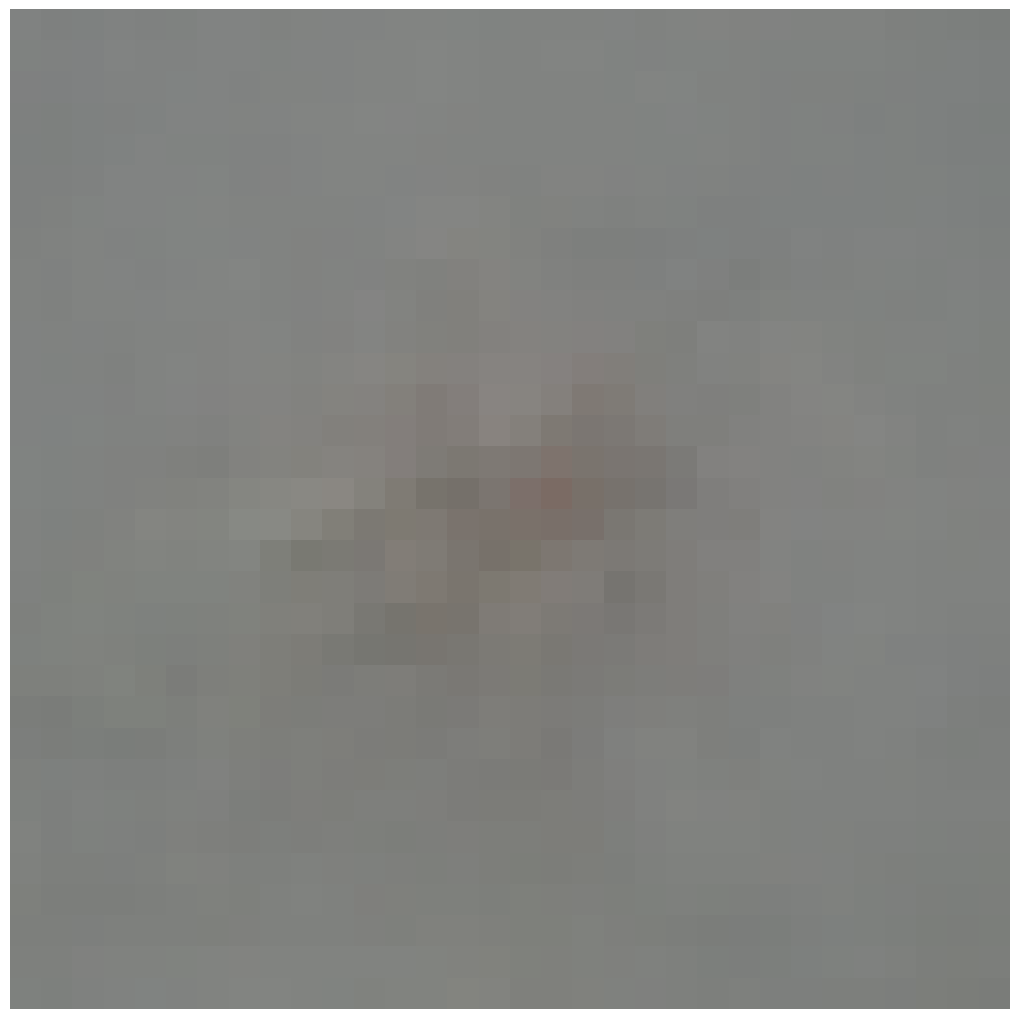

In [22]:
plot_images(cvx_comb)

In [23]:
eps = 1e-3
num_steps = 512
_, chan, w, h = x_samples.shape
batch_size = 16
t = torch.linspace(0, 1-eps, num_steps, device=device)
delta_t = t[1] - t[0]
x = torch.zeros(batch_size, chan, w, h, device= device)
s = torch.zeros(num_steps, batch_size, chan, w, h, device= device)
ss = torch.zeros(num_steps, batch_size, chan, w, h, device= device)


i = 0
for tt in t:
    score_estimate, cvx_comb = hard_score(x, x_samples, tt)
    #score_estimate = soft_score2(x, x_samples, tt)

    #print(f"Any NaN values: {torch.isnan(score_estimate).any().item()}")
    #print(f"Any Inf values: {torch.isinf(score_estimate).any().item()}")

    x  = x + score_estimate * delta_t + torch.randn_like(x, device=device) * torch.sqrt(delta_t)
    s[i, :, :, :, :] = cvx_comb
    ss[i, :, :, :, :] = x

    i += 1
    #print(tt.item(), end='\t')
    

In [24]:
plot_images(x, figsize=(6,6))


TypeError: plot_images() got an unexpected keyword argument 'figsize'

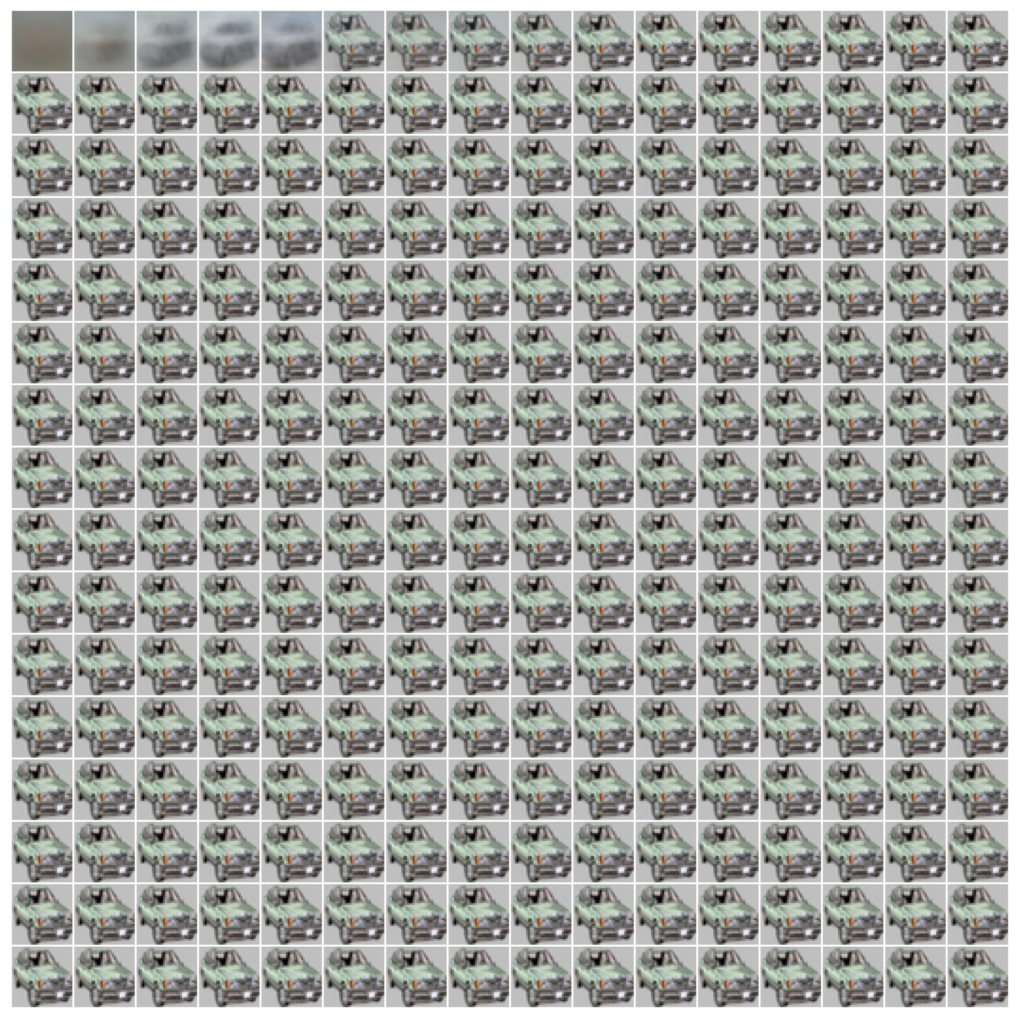

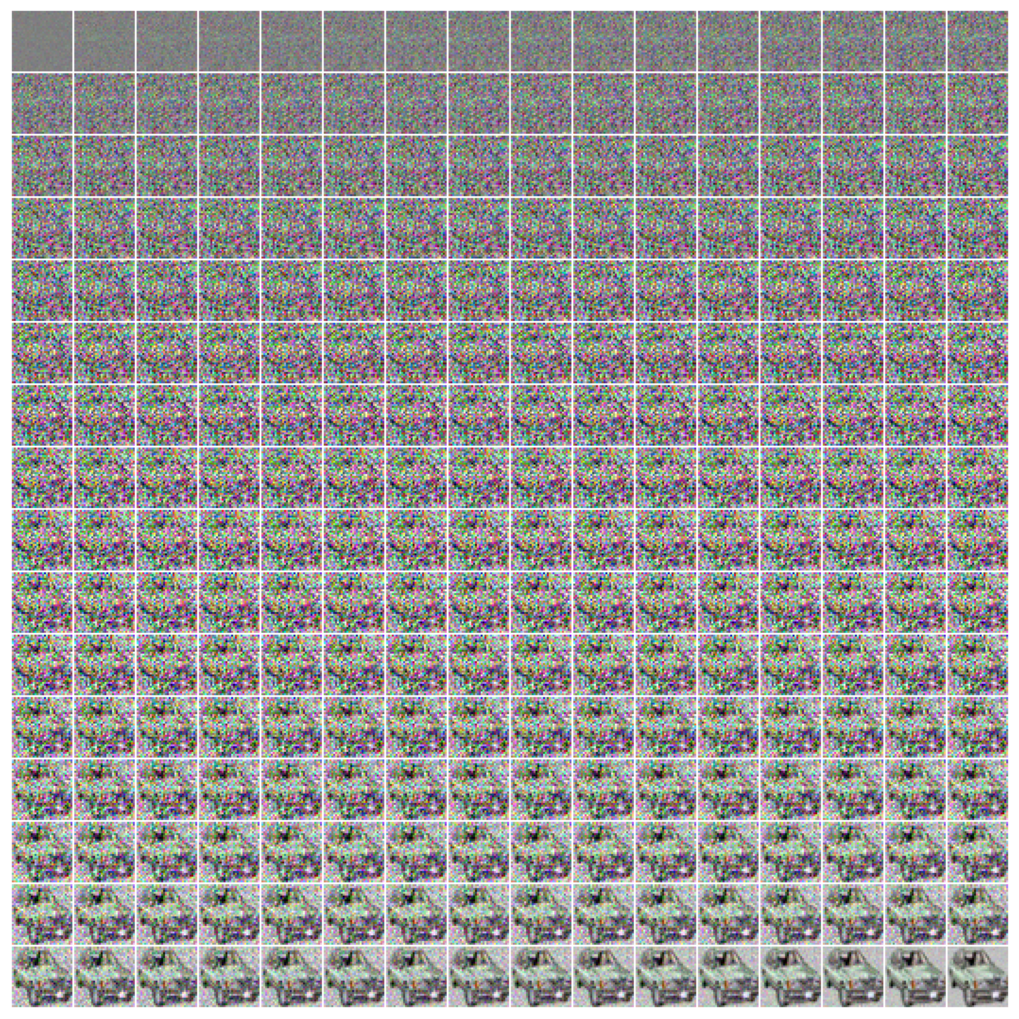

In [11]:
# Example usage:
# Assuming 'x' is your PyTorch tensor containing images
# plot_images(x, padding=2)

# Example usage:
# Assuming 'x' is your PyTorch tensor containing images
# plot_images(x, padding=2, bg_color=(0.95, 0.95, 0.95))
# Example usage:
k = 2
plot_images(s[0:-1:2,k,:,:,:])
plot_images(ss[0:-1:2,k,:,:,:])

0.9968885779380798


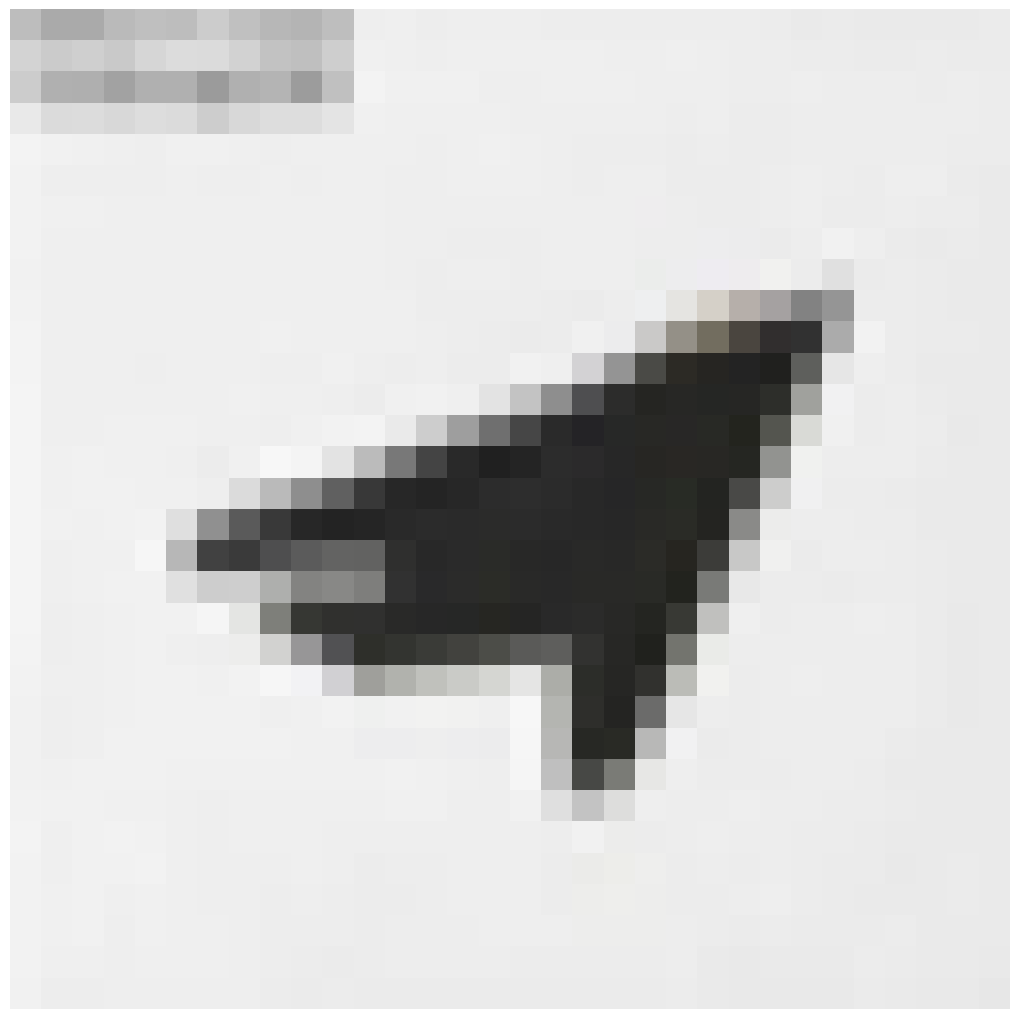

In [12]:
size, _, _, _ = x_samples.shape
k = -1
for i in range(size):
    a = torch.sum(x_samples[i, :, :, :] * x[k, :, :, :]) 
    b = torch.sum(x_samples[i, :, :, :] * x_samples[i, :, :, :]) * torch.sum(x[k, :, :, :] * x[k, :, :, :])
    corr = a / torch.sqrt(b) 
    if corr > 0.98:
       print(corr.item())
       plot_images(x_samples[i, :, :, :])
        